In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import nabatpy

In [3]:
# df = nabatpy.get_grts_data(grid_frame='Conus', state='North Carolina', high_priority=True)
df = nabatpy.get_grts_data(grid_frame='conus', state='Colorado', high_priority=True)

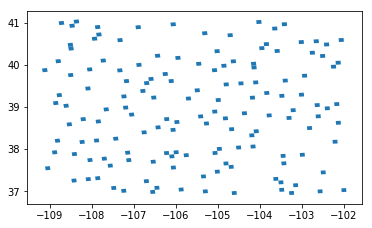

In [4]:
%matplotlib inline

df.plot()

In [35]:
b = df.iloc[11]['geometry']
b.bounds

(-104.86458183286211,
 37.61759189626176,
 -104.74003774316667,
 37.71468787904012)

In [36]:
import numpy as np
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

def reproject_tif(src_fname, dst_fname, dst_crs='EPSG:32613'):
    with rasterio.open(src_fname) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height,
            'nodata':-9999
        })

        with rasterio.open(dst_fname, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest,
                    dst_nodata=-9999)
                
#         with rasterio.open(dst_fname, '')

In [37]:
import owslib
from owslib.wcs import WebCoverageService

import rasterio
from rasterio.io import MemoryFile

wcs=WebCoverageService('https://elevation.nationalmap.gov:443/arcgis/services/3DEPElevation/ImageServer/WCSServer',version='1.0.0')
# this is the resolution for 1 arc second (30m DEM)
res = 0.00027777777803598

def get_elev(bounds):
    elev=wcs['DEP3ElevationPrototype']

    output = wcs.getCoverage(identifier='DEP3ElevationPrototype', bbox=bounds, format='GeoTIFF', resx=res, resy=res, crs=4326)
    contents = output.read()
    
    with open('elevation_raw.tif','wb') as f:
        f.write(contents)
    
    reproject_tif('elevation_raw.tif', 'elevation_utm.tif')
    
    with rasterio.open('elevation_utm.tif') as elev:
        data = elev.read(1)  
    
    return data


elev = get_elev(b.bounds)

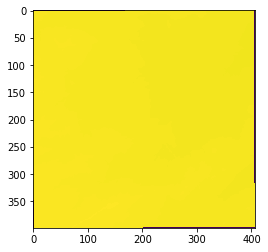

In [38]:
utm = rasterio.open('elevation_utm.tif')
#     data = src.read(1)
    

mask=utm.read_masks(1)

plt.imshow(utm.read(1))
utm.close()


In [44]:
from osgeo import gdal

def calculate_slope(DEM):
    gdal.DEMProcessing('slope.tif', DEM, 'slope', computeEdges=True, slopeFormat='percent')
    with rasterio.open('slope.tif') as dataset:
        slope=dataset.read(1)
    return np.ma.MaskedArray(slope, mask=~mask)

def calculate_aspect(DEM):
    gdal.DEMProcessing('aspect.tif', DEM, 'aspect', zeroForFlat=True)
    with rasterio.open('aspect.tif') as dataset:
        aspect=dataset.read(1)
    return np.ma.MaskedArray(aspect, mask=~mask)

def calculate_TRI(DEM):
    gdal.DEMProcessing('TRI.tif', DEM, 'TRI')
    with rasterio.open('TRI.tif') as dataset:
        tri = dataset.read(1)
    return np.ma.MaskedArray(tri, mask=~mask)

def calculate_TPI(DEM):
    gdal.DEMProcessing('TPI.tif', DEM, 'TPI')
    with rasterio.open('TPI.tif') as dataset:
        tpi = dataset.read(1)
    return np.ma.MaskedArray(tpi, mask=~mask)

def calculate_roughness(DEM):
    gdal.DEMProcessing('roughness.tif', DEM, 'Roughness')
    with rasterio.open('roughness.tif') as dataset:
        roughness = dataset.read(1)
    return np.ma.MaskedArray(roughness, mask=~mask)


slope=calculate_slope('elevation_utm.tif')
aspect=calculate_aspect('elevation_utm.tif')
tri = calculate_TRI('elevation_utm.tif')
tpi = calculate_TRI('elevation_utm.tif')
roughness = calculate_roughness('elevation_utm.tif')


'[[-9999.         -9999.         -9999.         ...,  1819.6027832\n   1819.36279297 -9999.        ]\n [ 1939.29541016  1938.19543457  1938.79101562 ...,  1818.80285645\n   1818.54284668 -9999.        ]\n [ 1950.41540527  1950.85546875  1951.17102051 ...,  1818.04284668\n   1817.78283691 -9999.        ]\n ..., \n [-9999.          1994.82189941  1994.83166504 ...,  1873.32775879\n   1873.10766602  1872.94775391]\n [-9999.          1997.36193848  1997.11169434 ...,  1873.22766113\n   1873.00769043  1872.78771973]\n [-9999.          2000.28198242  1999.49169922 ..., -9999.         -9999.\n  -9999.        ]]'

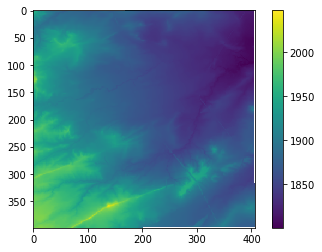

In [42]:
import matplotlib.pyplot as plt
plt.imshow(np.ma.MaskedArray(elev, mask=~mask))
plt.colorbar()

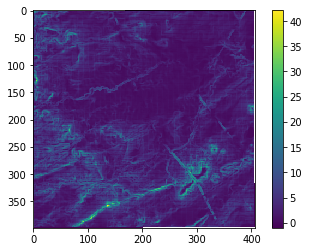

In [53]:

plt.imshow(roughness, vmin=-1)
plt.colorbar()

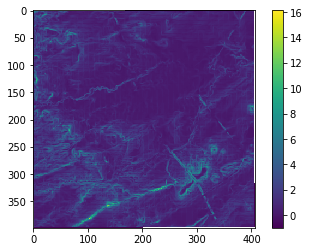

In [57]:
plt.imshow(tri, vmin=-1)
plt.colorbar()

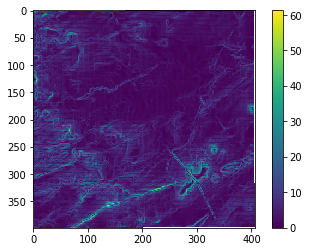

In [58]:
# slope[slope < 0] = 0

plt.imshow(slope)
plt.colorbar()

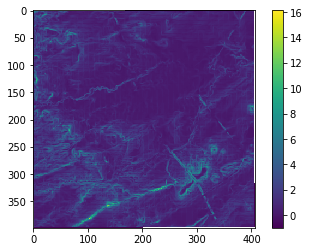

In [59]:
plt.imshow(tpi, vmin=-1)
plt.colorbar()

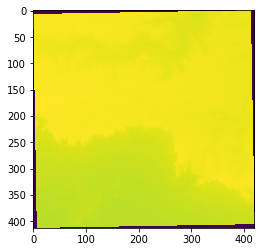

In [127]:
with rasterio.open('elev2.tif') as src:
    elev2 = src.read(1)
    
plt.imshow(elev2)

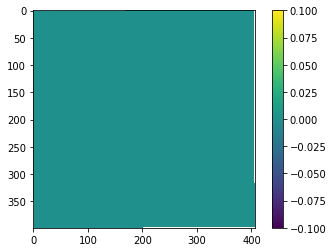

In [62]:
plt.imshow(tri-tpi)
plt.colorbar()

In [54]:
gdal.DEMProcessingOptions?


Signature: gdal.DEMProcessingOptions(options=[], colorFilename=None, format='GTiff', creationOptions=None, computeEdges=False, alg='Horn', band=1, zFactor=None, scale=None, azimuth=None, altitude=None, combined=False, multiDirectional=False, slopeFormat=None, trigonometric=False, zeroForFlat=False, callback=None, callback_data=None)
Docstring:
Create a DEMProcessingOptions() object that can be passed to gdal.DEMProcessing()
Keyword arguments are :
  options --- can be be an array of strings, a string or let empty and filled from other keywords.
  colorFilename --- (mandatory for "color-relief") name of file that contains palette definition for the "color-relief" processing.
  format --- output format ("GTiff", etc...)
  creationOptions --- list of creation options
  computeEdges --- whether to compute values at raster edges.
  alg --- 'ZevenbergenThorne' or 'Horn'
  band --- source band number to use
  zFactor --- (hillshade only) vertical exaggeration used to pre-multiply the elevatio

In [6]:
from __future__ import absolute_import
from __future__ import print_function
from owslib.wcs import WebCoverageService
wcs=WebCoverageService('http://cida.usgs.gov/thredds/wcs/prism',version='1.0.0')
# Take a look at the contents (coverages) of the wcs.
print(wcs.contents)
tmax=wcs['tmx']
# Take a look at the attributes of the coverage
dir(tmax)
# print(tmax.boundingBoxWGS84)
# print(tmax.timepositions)
# print(tmax.supportedFormats)
# mock up a simple GetCoverage request.
output=wcs.getCoverage(identifier='tmx',time=['1895-01-01T00:00:00Z'],bbox=b.bounds,format='GeoTIFF')
# Write the file out to disk.
f=open('foo.tif','wb')
f.write(output.read())
f.close()

{'tmn': <owslib.coverage.wcs100.ContentMetadata object at 0x000001B4466497F0>, 'ppt': <owslib.coverage.wcs100.ContentMetadata object at 0x000001B446649828>, 'tmx': <owslib.coverage.wcs100.ContentMetadata object at 0x000001B446649B70>}


In [7]:
f=open('foo4.tif','wb')
data = output.read()
f.write(data)
f.close()

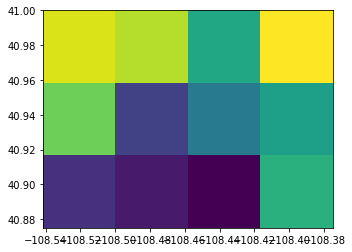

In [8]:
import rasterio
from rasterio import plot

ds = rasterio.open('foo4.tif')
plot.show(ds)

In [9]:
ds.close()

In [10]:
from __future__ import absolute_import
from __future__ import print_function
from owslib.wcs import WebCoverageService
wcs=WebCoverageService('https://elevation.nationalmap.gov:443/arcgis/services/3DEPElevation/ImageServer/WCSServer',version='1.0.0')
# Take a look at the contents (coverages) of the wcs.
print(wcs.contents)
elev=wcs['DEP3ElevationPrototype']
# # Take a look at the attributes of the coverage
# dir(tmax)
# # print(tmax.boundingBoxWGS84)
# # print(tmax.timepositions)
# # print(tmax.supportedFormats)
# # mock up a simple GetCoverage request.
output=wcs.getCoverage(identifier='DEP3ElevationPrototype', bbox=(-90,39,-89,41), format='GeoTIFF', resx=0.001, resy=0.001, crs=3857)
# Write the file out to disk.
f=open('foobar2.tif','wb')
f.write(output.read())
f.close()

{'DEP3ElevationPrototype': <owslib.coverage.wcs100.ContentMetadata object at 0x000001B4467F4588>, 'DEP3ElevationPrototype_Hillshade Gray': <owslib.coverage.wcs100.ContentMetadata object at 0x000001B4467F4128>, 'DEP3ElevationPrototype_Aspect Degrees': <owslib.coverage.wcs100.ContentMetadata object at 0x000001B4467F4518>, 'DEP3ElevationPrototype_Aspect Map': <owslib.coverage.wcs100.ContentMetadata object at 0x000001B4467F46D8>, 'DEP3ElevationPrototype_GreyHillshade_elevationFill': <owslib.coverage.wcs100.ContentMetadata object at 0x000001B4467F48D0>, 'DEP3ElevationPrototype_Hillshade Multidirectional': <owslib.coverage.wcs100.ContentMetadata object at 0x000001B4467F4048>, 'DEP3ElevationPrototype_Slope Map': <owslib.coverage.wcs100.ContentMetadata object at 0x000001B4467F42E8>, 'DEP3ElevationPrototype_Slope Degrees': <owslib.coverage.wcs100.ContentMetadata object at 0x000001B4467F4400>, 'DEP3ElevationPrototype_Hillshade Elevation Tinted': <owslib.coverage.wcs100.ContentMetadata object at 

In [11]:
dir(elev)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_elem',
 '_getAxisDescriptionsProperty',
 '_getGrid',
 '_getOtherBoundingBoxes',
 '_getSupportedCRSProperty',
 '_getSupportedFormatsProperty',
 '_getTimeLimits',
 '_getTimePositions',
 '_service',
 'abstract',
 'axisDescriptions',
 'boundingBox',
 'boundingBoxWGS84',
 'boundingboxes',
 'crsOptions',
 'defaulttimeposition',
 'grid',
 'id',
 'keywords',
 'styles',
 'supportedCRS',
 'supportedFormats',
 'timelimits',
 'timepositions',
 'title']

In [12]:
elev.supportedCRS

[urn:ogc:def:crs:EPSG::4326,
 urn:ogc:def:crs:EPSG::3857,
 urn:ogc:def:crs:EPSG::3857]

In [13]:

from owslib.wcs import WebCoverageService
wcs=WebCoverageService('https://elevation.nationalmap.gov:443/arcgis/services/3DEPElevation/ImageServer/WCSServer',version='1.0.0')
# Take a look at the contents (coverages) of the wcs.
print(wcs.contents)
elev=wcs['DEP3ElevationPrototype']

output=wcs.getCoverage(identifier='DEP3ElevationPrototype', bbox=(-90,39,-89,41), format='GeoTIFF', resx=0.001, resy=0.001, crs=4326)

# Write the file out to disk.
data = output.read()
f=open('foobar2.tif','wb')
f.write(data)
f.close()

{'DEP3ElevationPrototype': <owslib.coverage.wcs100.ContentMetadata object at 0x000001B4467FB0B8>, 'DEP3ElevationPrototype_Hillshade Gray': <owslib.coverage.wcs100.ContentMetadata object at 0x000001B4467FB550>, 'DEP3ElevationPrototype_Aspect Degrees': <owslib.coverage.wcs100.ContentMetadata object at 0x000001B4467FBDD8>, 'DEP3ElevationPrototype_Aspect Map': <owslib.coverage.wcs100.ContentMetadata object at 0x000001B4467FBBE0>, 'DEP3ElevationPrototype_GreyHillshade_elevationFill': <owslib.coverage.wcs100.ContentMetadata object at 0x000001B4467FB278>, 'DEP3ElevationPrototype_Hillshade Multidirectional': <owslib.coverage.wcs100.ContentMetadata object at 0x000001B4467FB0F0>, 'DEP3ElevationPrototype_Slope Map': <owslib.coverage.wcs100.ContentMetadata object at 0x000001B4467FBE80>, 'DEP3ElevationPrototype_Slope Degrees': <owslib.coverage.wcs100.ContentMetadata object at 0x000001B4467FB2B0>, 'DEP3ElevationPrototype_Hillshade Elevation Tinted': <owslib.coverage.wcs100.ContentMetadata object at 

In [14]:
elev.boundingBoxWGS84

(-179.99998854118687,
 -15.001663244822502,
 179.99999272129153,
 84.00167857213272)

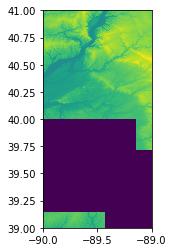

In [15]:
import rasterio
from rasterio import plot

ds = rasterio.open('foobar2.tif')
plot.show(ds)

data = ds.read(1)

ds.close()

In [17]:
truth = rasterio.open(r"C:\Users\talbertc\Downloads\USGS_NED_1_n37w113_GridFloat\usgs_ned_1_n37w113_gridfloat.flt")
truth_data = truth.read(1)

In [ ]:
left, bottom, right, top =list(truth.bounds)
res = 0.00027777777803598  # this is the resolution for 1 arc second (30m DEM)

# A subset size for our comparison
pixels = 400

x_offset, y_offset = 3000, 3000

offset_left = left + x_offset * res
offset_top = top - y_offset * res

right = offset_left + pixels * res
bottom = offset_top - pixels * res

truth_subset = truth_data[ y_offset:y_offset+pixels, x_offset:x_offset+pixels]



In [ ]:
elev=wcs['DEP3ElevationPrototype']

output=wcs.getCoverage(identifier='DEP3ElevationPrototype', bbox=(offset_left, bottom, right, offset_top), format='GeoTIFF', resx=res, resy=res, crs=4326)

# Write the file out to disk.
data = output.read()
f=open('service_return2.tif','wb')
f.write(data)
f.close()

service = rasterio.open("service_return2.tif")
service_data = service.read(1)

service.close()

In [ ]:
import matplotlib.pyplot as plt

diff  = truth_subset - service_data
plt.imshow(diff)
plt.colorbar()

In [ ]:
# ax = plot.show(truth, cmap=plt.cm.gist_earth, title='The Grand Canyon \n(USGS NED 1 arc-second n37w113 1 x 1 degree GridFloat 2018)')

fig, axes = plt.subplots(1,4, figsize=(30, 7))

orig, orig_subset, service, diff_plot = axes.flatten()

orig.imshow(truth_data, interpolation='nearest', cmap=plt.cm.gist_earth, extent=plot.plotting_extent(truth))
orig.plot([offset_left, right], [offset_top, offset_top],  'k-', lw=2, c='red')
orig.plot([right, right], [offset_top, bottom],  'k-', lw=2, c='red')
orig.plot([offset_left, right], [bottom, bottom],  'k-', lw=2, c='red')
orig.plot([offset_left, offset_left], [bottom, offset_top],  'k-', lw=2, c='red')
orig.set_title('The Grand Canyon \n(USGS NED 1 arc-second n37w113)')

orig_subset.imshow(truth_subset, interpolation='nearest', cmap=plt.cm.gist_earth)
orig_subset.set_title('Orig Subset')

service.imshow(service_data, interpolation='nearest', cmap=plt.cm.gist_earth)
service.set_title('Orig Subset')

diff_data  = truth_subset - service_data
diff_im = diff_plot.imshow(diff_data)
diff_plot.set_title('Original - Service')
plt.colorbar(diff_im);

plt.tight_layout()